# Predicting the Sale Price of Bulldozers using Machine Learning

This notebook contains a machine learning project with the goal of predicting the sale price of bulldozers.

# 1. Problem definition

> How well can we predict the future sale price of a bulldozer given its characteristics and previous examples of how much similar bulldozers have been sold for?


# 2. Data

The data is downloaded from the Kaggle Bluebook Bulldozer competition. There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

For more on this data, check: https://www.kaggle.com/c/bluebook-for-bulldozers/data.


# 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project, check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation.



# 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. Check it on Google Sheets: https://docs.google.com/spreadsheets/d/16giVhsqzp85im3JSJkazT_jV_t4XLlpoCDb8FJgRFUw/edit#gid=1515256356.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
# import training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainandValid.csv",
                 low_memory=False)
    # low_memory=False prevents a warning message

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [3]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

* This dataset has over 400k rows!
* We want to predict feature SalePrice
* There are missing values in many features!

Let's compare sale dates with sale prices. Instead of plotting all 400k+ values, we plot part of it.

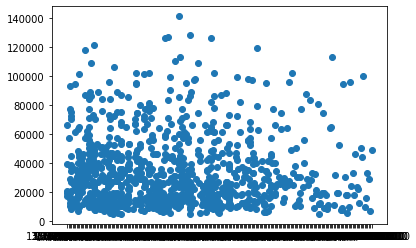

In [5]:
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000]);

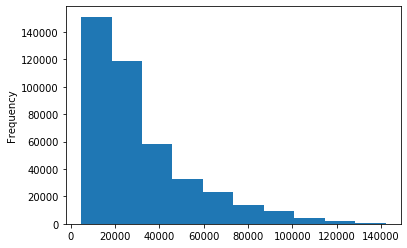

In [6]:
df.SalePrice.plot.hist();

In [7]:
df.saledate[:10]

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
5    12/18/2008 0:00
6     8/26/2004 0:00
7    11/17/2005 0:00
8     8/27/2009 0:00
9      8/9/2007 0:00
Name: saledate, dtype: object

### Parsing dates

When working with time series data, we want to enrich the time & date component as much as possible. We can do that by telling pandas which of our column has dates in it using the `parse_dates` parameter.

In [16]:
# Import data again but this time parse dates
df = pd.read_csv("data/bluebook-for-bulldozers/TrainandValid.csv",
                 low_memory=False,
                 parse_dates = ["saledate"])

In [17]:
df.saledate[:10]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

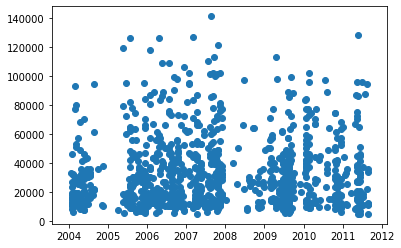

In [18]:
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000]);

Note the x-axis is much more readable now, and we get a much better idea than before.

In [19]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [21]:
df.saledate[:20]

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

Note that the dates are all scrambled.

### Sort dataframe by saledate

In [22]:
# Sort dataframe in date order

df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original dataframe

We make a copy of this sorted dataframe so when we manipulate the copy, we've still got our original data. And from now on we'll work with this copy.

In [23]:
# Make a copy
df_tmp = df.copy()

## Feature Engineering

### Add datetime parameters for `saledate` column

https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DatetimeIndex.html

In [24]:
# add a few date columns
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

# drop the saledate column
df_tmp.drop("saledate", axis=1, inplace=True)

In [25]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


### State column

In [26]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

### Convert strings to categories

One way we can turn all of our data into numbers is by converting them into pandas categories.

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/version/0.25.3/reference/general_utility_functions.html#data-types-related-functionality

In [27]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [28]:
# Find columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)
        
# df_tmp.items treats our dataframe as a dictionary
    # keys = column names
    # values = column values

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [29]:
# Turn all string values into category values

for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

        # as_ordered(): orders the levels of the categories
        # and each category will be represented as a value

df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [30]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [31]:
# All string values have been turned into categories with numerical values
# E.g. for the state column:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [32]:
# Save preprocessed data
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv", index=False)

# Import preprocessed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv",
                     low_memory=False)

We now have a way to access all of our data in the form of numbers. But we still have many missing values.

### Filling in numerical missing data

We will fill missing numerical values with the median of the corresponding column.

In [33]:
# Percentage of missing data per column
df_tmp.isna().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [34]:
# Fill in the missing data in numeric columns with the median

for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content): # if column is numeric
        if pd.isnull(content).sum(): # and contains missing values
            
            # Add a binary column which tells us if the data was missing
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

# We add a column that tells if the data was missing just in case that data
# was missing for some important reason. Introducing this new column will give
# to our model the information that that entry was missing before, which may/may not
# be important.

# We use the median instead of the mean, because median is more robust,
# e.g. it is less sensitive to outliers!

# Note: we could write pd.isnull(content).sum()>0 but in an if-statement
# Python converts a number to bool and every nonzero integer is converted to True
# and 0 is converted to False, so we don't need to add '>0'.

In [35]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content): # if column is numeric
        if pd.isnull(content).sum(): # and contains missing values
            print(label)
            
# This prints out nothing, as we wanted!

In [36]:
df_tmp.auctioneerID.isna().sum()

0

In [37]:
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

### Filling categorical missing values

We're going to replace each category in a categorical column by its corresponding code. Missing values are automatically given code -1 in a categorical column, so we add 1 to each code to prevent us from dealing with negative numbers.

In [38]:
# Filling missing values in categorical columns

for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content): # if column is NOT numeric
            
        # Add binary column to indicate whether sample has missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)

        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes + 1

# The reason why we add +1 is because Python automatically gives code -1 to missing values
# in a categorical column, and we don't want negative numbers, so we change it to be 0!

In [39]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

As we can see, there are no more missing values!


## 5. Modelling

Let's do some modelling. This is a regression problem, so let's try a Random Forest Regressor.

In [154]:
%%time
# this measures how long this cell takes to run

# Let's build a machine learning model

X = df_tmp.drop("SalePrice", axis=1)
y = df_tmp["SalePrice"]

from sklearn.ensemble import RandomForestRegressor

# Instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)
    # n_jobs=-1 sets the compute to use as many cores/processors as possible
    # random_state=42 is a replacement for np.random.seed(42)

# Fit the model
model.fit(X, y)

CPU times: user 12min 17s, sys: 4.07 s, total: 12min 21s
Wall time: 3min 16s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

This ML model takes too long to train, so we need to come up with ways to make it faster!

In [155]:
# Score the model
model.score(X, y)

0.987551349795339

However, this is an optimistic estimate of our out-of-sample error. For a better estimate, we must use a test or validation set!

### Splitting data into train/validation sets

Since this is time-series data, we need to be careful how we split it. According to the documentation:
* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

In [156]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [157]:
# Split data into training and validation

df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_train), len(df_val)

(401125, 11573)

In [158]:
# Split data into X & y

X_train = df_train.drop("SalePrice", axis=1)
y_train = df_train["SalePrice"]

X_val = df_val.drop("SalePrice", axis=1)
y_val = df_val["SalePrice"]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 102), (401125,), (11573, 102), (11573,))

**Correction:** We should have splitted our data before filling in the missing values, otherwise the training data is influencing the validation data and vice-versa!

## Building our own evaluation function

In [167]:
# create evaluation function for RMSLE
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_val, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_val, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_val, val_preds)}
    return scores

## Testing our model on a subset (to tune hyperparameters)

Since our model takes a long time to train, we will test it on a subset, and tune hyperparameters this way. One option is to train it on 10k rows (instead of the total of 400k+). But the Random Forest Regressor has a max_samples hyperparameter that it's really useful here.

In [164]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

# Now our model will run Random Forest Regressor with n_estimators=100 trees
# on training data of 10k rows!

In [165]:
%%time
# Cutting down on the max number of samples improves model runtime
model.fit(X_train, y_train)

CPU times: user 29.3 s, sys: 693 ms, total: 30 s
Wall time: 10.4 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [168]:
show_scores(model)

{'Training MAE': 5567.236797232783,
 'Valid MAE': 7167.089238745356,
 'Training RMSLE': 0.25797216373820187,
 'Valid RMSLE': 0.293211735920372,
 'Training R^2': 0.8605325040104918,
 'Valid R^2': 0.8326021487668128}

## Hyperparameter tuning with RandomizedSearchCV

In [171]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]
}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   58.8s finished


CPU times: user 28.2 s, sys: 4.56 s, total: 32.7 s
Wall time: 1min 2s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [172]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 50,
 'min_samples_split': 6,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 3}

In [173]:
# Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 11600.107123157426,
 'Valid MAE': 13169.36177513019,
 'Training RMSLE': 0.49467717061668115,
 'Valid RMSLE': 0.49952351011519003,
 'Training R^2': 0.4958619533106503,
 'Valid R^2': 0.48906007957878694}

This is worse than what we had at the beginning, but it's understandable since the RandomizedSearchCV is only trying out n_iter=2 combinations of hyperparameters. To get a  better estimate of the best hyperparams, we could try n_iter=100 combinations (which would take 50 times longer, in our case a little over 1h) and let the computer run during lunch-time. We now use the hyperparams the course teacher has obtained with n_iter=100!

### Train the model with the best hyperparameters

In [176]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: user 2min 17s, sys: 1.52 s, total: 2min 19s
Wall time: 43.2 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [179]:
# Scores for ideal model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2949.370825582429,
 'Valid MAE': 5956.613181856461,
 'Training RMSLE': 0.14443748823161592,
 'Valid RMSLE': 0.24614543130162314,
 'Training R^2': 0.9589790407606988,
 'Valid R^2': 0.8815412159453595}

In [181]:
# Scores for rs_model (only trained on ~10k examples)
show_scores(rs_model)

{'Training MAE': 11600.107123157426,
 'Valid MAE': 13169.36177513019,
 'Training RMSLE': 0.49467717061668115,
 'Valid RMSLE': 0.4995235101151901,
 'Training R^2': 0.4958619533106503,
 'Valid R^2': 0.48906007957878683}

## Make predictions on the test data

In [184]:
# Import test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head()
# Note that this dataset does not have a SalePrice column,
# because that's the one we're trying to predict!

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


#### Preprocess the test data set
* still contains missing data
* some columns are still non-numerical
* there are less columns than in X_train, because we're missing the columns that tell us which rows had missing categorical data

In [191]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    
    # add a few date columns
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear

    # drop the saledate column
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill in the missing data in numeric columns with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content): # if column is numeric
            if pd.isnull(content).sum(): # and contains missing values

                # Add a binary column which tells us if the data was missing
                df[label+"_is_missing"] = pd.isnull(content)

                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
    # Turn all string values into category values
    for label, content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()
            # as_ordered(): orders the levels of the categories
            # and each category will be represented as a value
    
    # Filling missing values in categorical columns
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content): # if column is NOT numeric

            # Add binary column to indicate whether sample has missing value
            df[label+"_is_missing"] = pd.isnull(content)

            # Turn categories into numbers and add +1
            df[label] = pd.Categorical(content).codes + 1
    
    return df

In [192]:
# Process the test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


There are 101 columns and, upon comparing with X_train, there should be 102 columns! It turns out that the column missing is auctioneerID_is_missing. This column was created in X_train to account for all rows with missing auctioneerID value but df_test didn't have any auctioneerID missing values. That's why preprocessing it did not create that column! So let's add it manually to df_test, and make predictions:

In [194]:
# Find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [196]:
# Manually add this column to df_test
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [198]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)
test_preds

array([24521.65753003, 15297.12548544, 54044.53259772, ...,
       15945.16446732, 28775.19353783, 38279.56332324])

## Formatting and exporting

Kaggle requires the predictions to be in a specific format:

>Sample submission files can be downloaded from the data page. Submission files should be formatted as follows:
>
>Have a header: "SalesID,SalePrice"
>Contain two columns
>SalesID: SalesID for the validation set in sorted order
>SalePrice: Your predicted price of the sale

https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [199]:
# Formatting predictions

df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,24521.657530
1,1227844,15297.125485
2,1227847,54044.532598
3,1227848,62539.172727
4,1227863,40788.563127
...,...,...
12452,6643171,55438.133804
12453,6643173,21913.687503
12454,6643184,15945.164467
12455,6643186,28775.193538


In [200]:
# Export prediction data

df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv", index=False)

### Feature Importance

Which data features were the most important for prediciting the **target variable** (SalePrices).

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html (feature_importances_)

In [201]:
# Find feature importance of our best model

ideal_model.feature_importances_

array([3.24777560e-02, 1.77686395e-02, 4.11903220e-02, 1.85071995e-03,
       3.35378149e-03, 2.01596544e-01, 3.12709585e-03, 1.06589017e-03,
       4.55351467e-02, 3.70368717e-02, 7.04811346e-02, 4.50861304e-03,
       2.87972110e-02, 1.53273621e-01, 4.21391050e-02, 5.88223936e-03,
       3.87650274e-03, 4.51749163e-03, 3.84838676e-03, 5.60316955e-02,
       5.36162455e-04, 5.59572425e-05, 6.16214280e-04, 1.76778691e-04,
       1.34958053e-03, 1.04494493e-04, 3.93168003e-03, 6.27201192e-03,
       2.61899209e-04, 1.41708629e-04, 5.06242057e-03, 5.40421296e-03,
       2.94874488e-03, 5.31473551e-04, 2.76022010e-03, 1.52663865e-02,
       8.21926094e-04, 1.67878773e-02, 2.60516890e-03, 1.74348192e-03,
       1.28792009e-03, 8.97909763e-04, 1.22383820e-03, 6.07761403e-04,
       7.67338520e-04, 3.35876649e-04, 4.86961882e-04, 2.59488860e-03,
       7.58328725e-04, 1.77895663e-04, 2.61315609e-04, 7.42455900e-02,
       3.80369536e-03, 5.65899366e-03, 2.95072331e-03, 9.82321579e-03,
      

In [202]:
X_train.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing',
       'fiModelDesc_is_missing', 'fiBaseModel_is_missing',
       'fiProductClassDesc_is_missing', 'state_is_missing',
       'ProductGroup_is_missing', 'ProductGroupDesc_is_missing'],
      dtype='object', length=102)

In [210]:
# Helper function for plotting feature importance

def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe in horizontal bar plot
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    
    ax.invert_yaxis() # to get highest bar on top

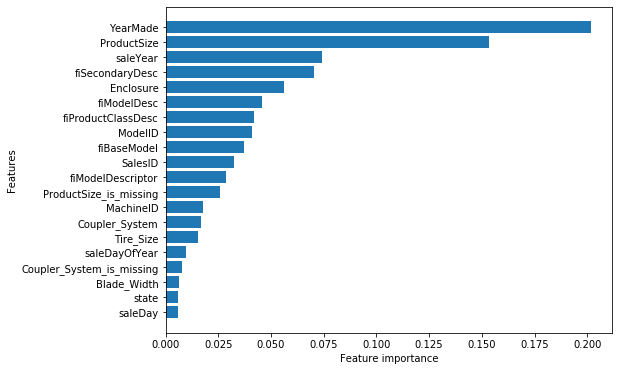

In [211]:
plot_features(X_train.columns, ideal_model.feature_importances_)

**Question to finish:** Why might knowing the feature importances of a trained ML model be helpful?

This can be useful for:
* discussing with a specialist to get a sense if it makes sense;
* building further models.

**Final challenge:** What other ML models can I try in our dataset? Check Scikit-Learn model map, or try something like CatBoost.ai or XGBoost.ai.